##**Car Selling Price Prediction**

Author: Junwei Shen & Che Zhu

#1. Loading packages and Reading Data Info



In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor,plot_tree
from statsmodels.stats import diagnostic
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction import FeatureHasher

from lightgbm import LGBMRegressor,plot_tree

In [ ]:
# Loading dataset
df = pd.read_csv('/content/car_prices.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB


In [ ]:
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


In [ ]:
df.nunique()

year                34
make                96
model              973
trim              1963
body                87
transmission         4
vin             550297
state               64
condition           41
odometer        172278
color               46
interior            17
seller           14263
mmr               1101
sellingprice      1887
saledate          3766
dtype: int64

#2. Preprocessing and EDA

In [ ]:
df.isnull().sum()

year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65352
vin                 4
state               0
condition       11820
odometer           94
color             749
interior          749
seller              0
mmr                38
sellingprice       12
saledate           12
dtype: int64

##2.1 Categorical Features missing value

In [ ]:
# Drop missing value for some categorical features
cat_col_1 = ['make', 'model', 'trim', 'body', 'transmission', 'color', 'interior', 'state']
df = df.dropna(subset = cat_col_1)

# Drop missing value for unique categorical features
cat_col_2 = ['vin', 'saledate', 'seller']
df = df.dropna(subset = cat_col_2)

In [ ]:
# Checking missing values
missing_values_after = df.isnull().sum()
missing_values_after

year               0
make               0
model              0
trim               0
body               0
transmission       0
vin                0
state              0
condition       9423
odometer          54
color              0
interior           0
seller             0
mmr               22
sellingprice       0
saledate           0
dtype: int64

##2.2 Numerical Features missing value

In [ ]:
# Impute missing values for 3 numerical columns with the median
num_col_1 = ['sellingprice', 'odometer', 'mmr', 'condition']
for col in num_col_1:
    df[col].fillna(df[col].median(), inplace=True)

In [ ]:
# Checking missing values
missing_values_after = df.isnull().sum()
missing_values_after

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64

In [ ]:
# Checking remaining number of rows
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 481769 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          481769 non-null  int64  
 1   make          481769 non-null  object 
 2   model         481769 non-null  object 
 3   trim          481769 non-null  object 
 4   body          481769 non-null  object 
 5   transmission  481769 non-null  object 
 6   vin           481769 non-null  object 
 7   state         481769 non-null  object 
 8   condition     481769 non-null  float64
 9   odometer      481769 non-null  float64
 10  color         481769 non-null  object 
 11  interior      481769 non-null  object 
 12  seller        481769 non-null  object 
 13  mmr           481769 non-null  float64
 14  sellingprice  481769 non-null  float64
 15  saledate      481769 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 62.5+ MB


##2.3 Some interesting plot for EDA

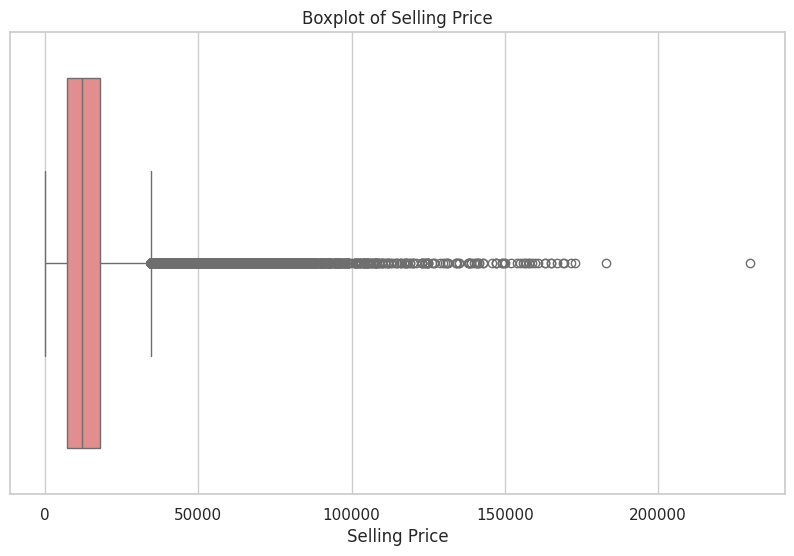

In [ ]:
sns.set(style="whitegrid")

# Creating the boxplot for the 'sellingprice' variable
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['sellingprice'],color='lightcoral')
plt.title('Boxplot of Selling Price')
plt.xlabel('Selling Price')
plt.show()

In [ ]:
# For outliers in 'sellingprice', let's calculate the IQR and use it to define outliers
Q1 = df['sellingprice'].quantile(0.25)
Q3 = df['sellingprice'].quantile(0.75)
IQR = Q3 - Q1
outlier_thresholds = [Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]

# Number of outliers in 'sellingprice'
num_outliers = df[(df['sellingprice'] < outlier_thresholds[0]) | (df['sellingprice'] > outlier_thresholds[1])].shape[0]

outlier_thresholds, num_outliers

([-9500.0, 34500.0], 14371)

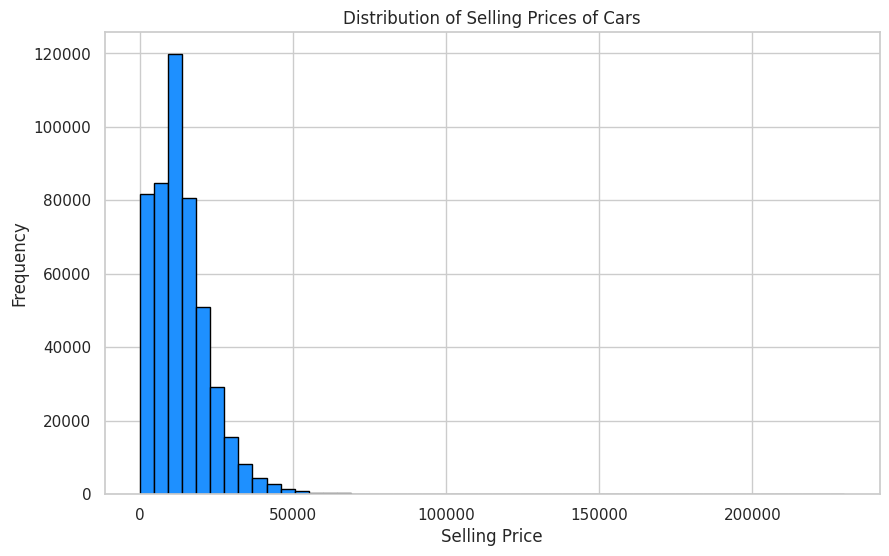

In [ ]:
# Plotting the histogram for distribution of the selling price
plt.figure(figsize=(10, 6))
plt.hist(df['sellingprice'], bins=50, color='dodgerblue', edgecolor='black')
plt.title('Distribution of Selling Prices of Cars')
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

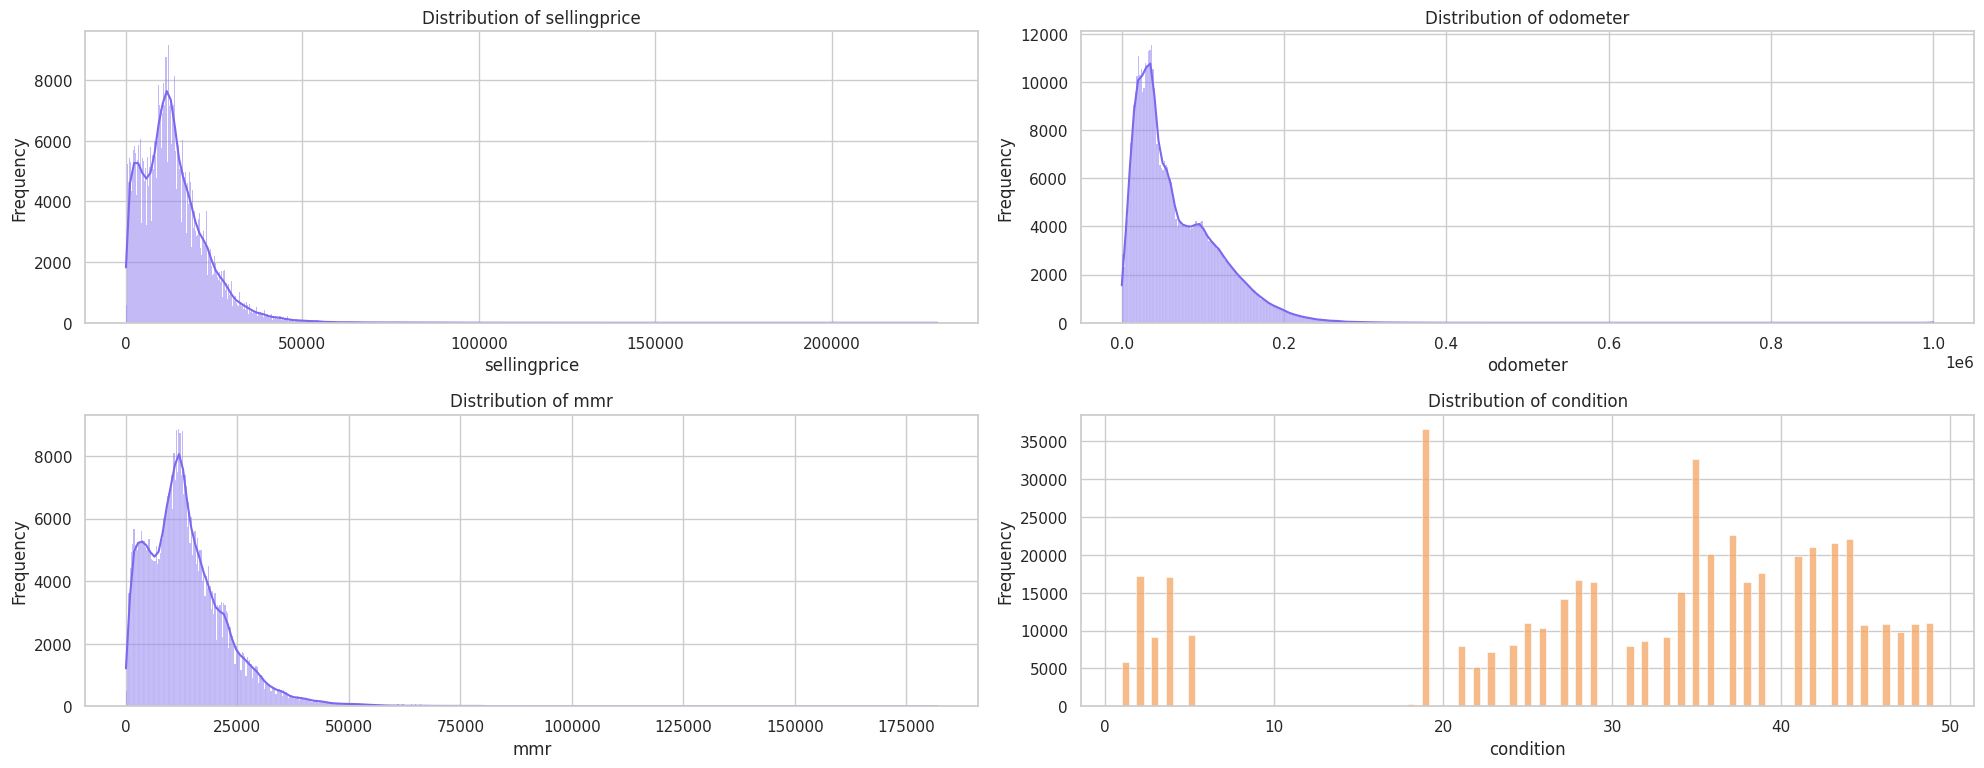

In [ ]:
# Identifying columns to plot
columns_to_plot = [col for col in ['sellingprice', 'odometer', 'mmr', 'condition']]

# Plotting distributions of the selected columns
plt.figure(figsize=(20, 15))
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(len(columns_to_plot), 2, i)
    if col == "condition":
        sns.histplot(df[col], kde=False, color='sandybrown')
    else:
        sns.histplot(df[col], kde=True, color='mediumslateblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

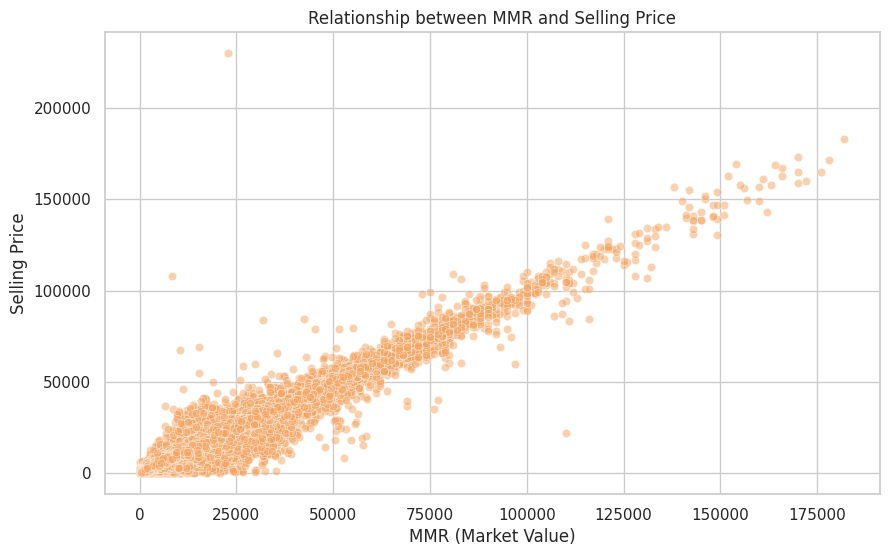

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='mmr', y='sellingprice', data=df, alpha=0.5, color = 'sandybrown')
plt.title('Relationship between MMR and Selling Price')
plt.xlabel('MMR (Market Value)')
plt.ylabel('Selling Price')
plt.show()

#3. Feature Engineering

In [ ]:
df['saledate'].isna().any()

False

In [ ]:
def body_shorten(body):
    body_lower = body.lower().split()
    basic_body = ['suv', 'sedan', 'convertible', 'coupe', 'wagon', 'hatchback', 'cab','minivan', 'van']
    for element in body_lower:
        if element in basic_body:
            return element
    return 'other'


def make_fix(make):
    make = make.lower().split()[0]
    model_map = {
        'mercedes': 'mercedes-benz',
        'gmc truck': 'gmc',
        'mercedes-b': 'mercedes-benz',
        'vw': 'volkswagen',
        'chev': 'chevrolet'
    }
    if make in model_map.keys():
        make = model_map['chev']

    return make

In [ ]:
df_backup = df.copy()

In [ ]:
# Convert saledate to datetime
df['saledate'] = pd.to_datetime(df['saledate'], errors='coerce')
df = df.dropna(subset = 'saledate')

df['car_year'] = df['saledate'].apply(lambda x : x.year) - df['year']
df.loc[df['car_year'] < 0, 'car_year'] = 0

df['make'] = df['make'].apply(make_fix)

df['body'] = df['body'].apply(body_shorten)

In [ ]:
df['body'].value_counts()

sedan          221935
suv            123645
cab             29546
hatchback       24215
minivan         22449
coupe           18395
wagon           14638
other           12233
convertible      9949
van              4742
Name: body, dtype: int64

<ipython-input-21-ebc9337baf84>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


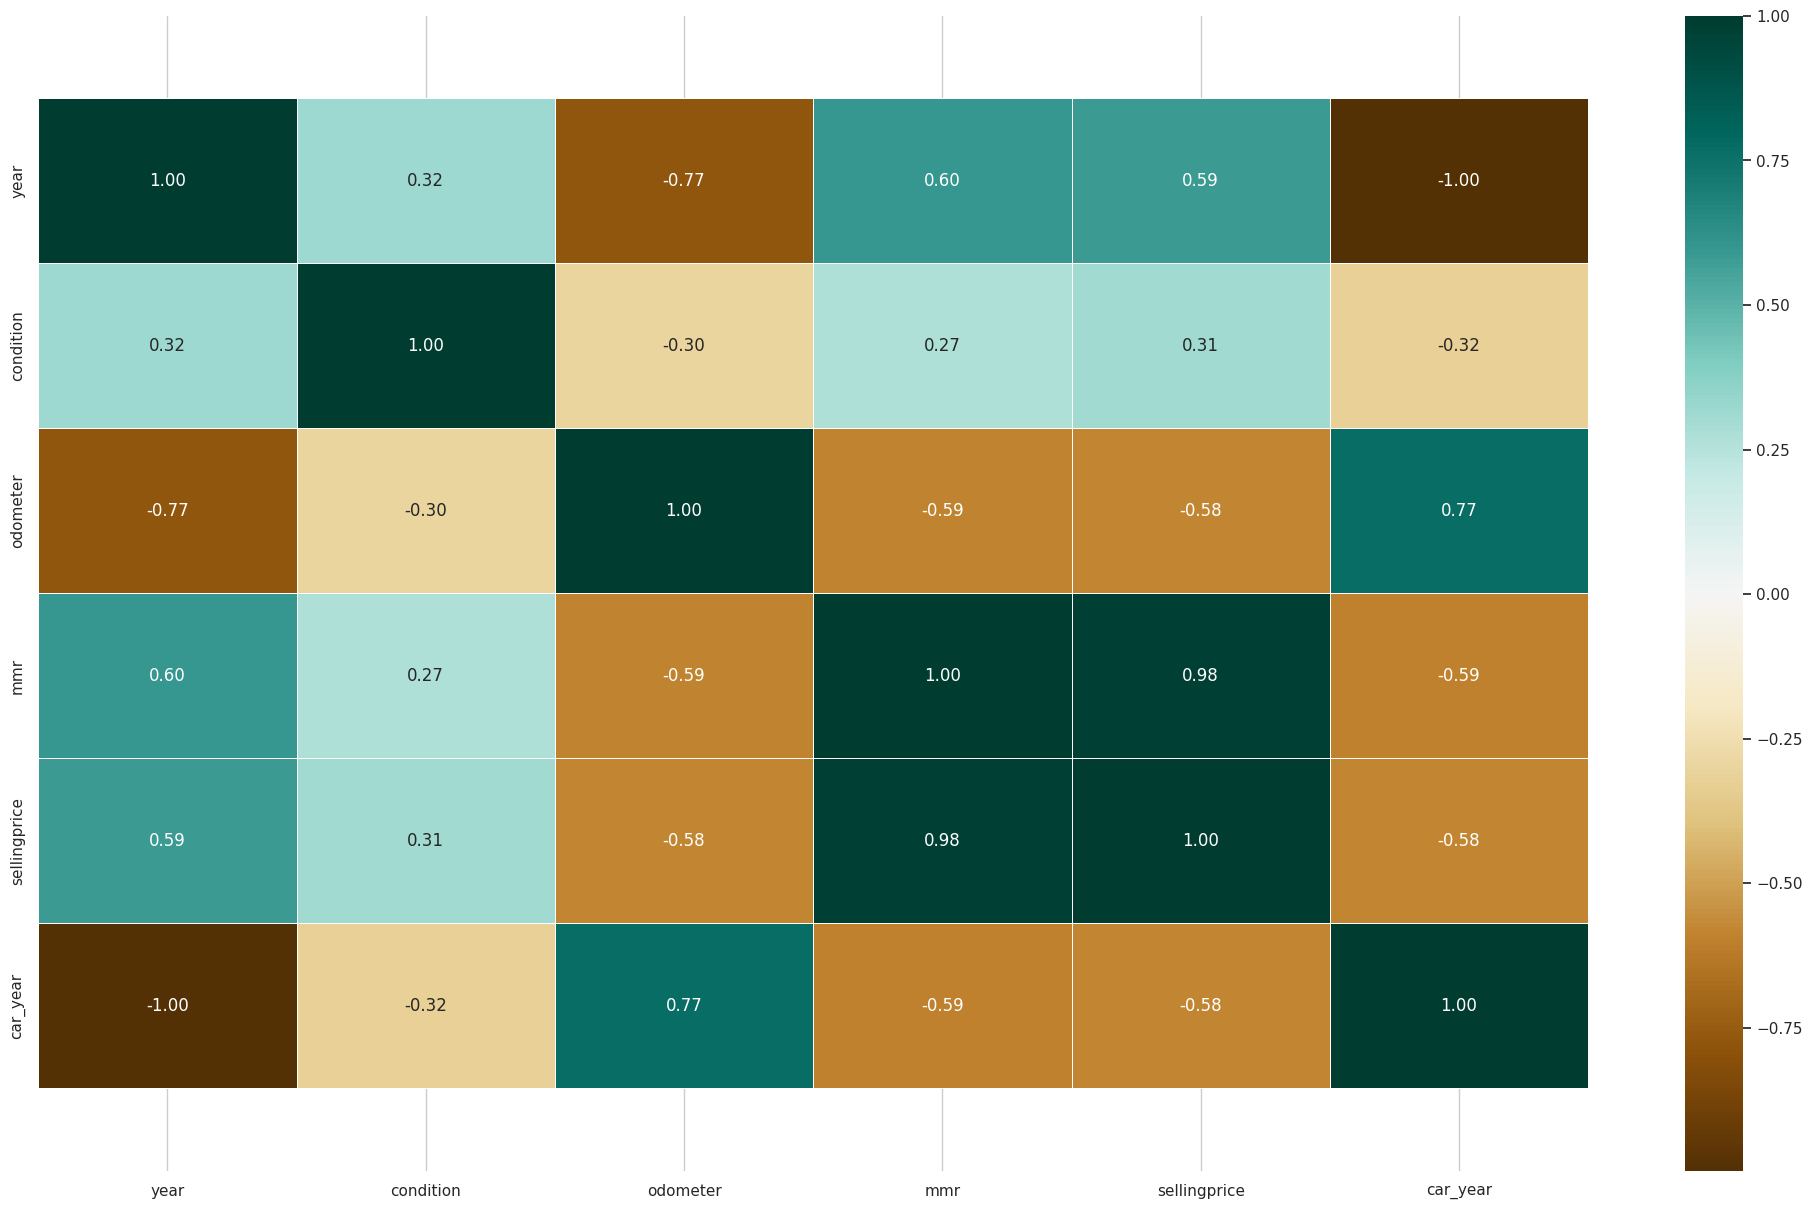

In [ ]:
# Corralation Matrix
corr_matrix = df.corr()
fig, ax = plt.subplots(figsize=(25, 15))
ax = sns.heatmap(corr_matrix, annot=True, linewidths=0.5, fmt=".2f", cmap='BrBG');
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [ ]:
# Adopted from https://www.kaggle.com/code/mrudhuhas/car-price-prediction#Random-Forest with compatibility edit
# Hasher from model and trim feature to reduce demensionality

hasher = FeatureHasher(n_features=40, input_type='string')
hashed_features = hasher.transform(df[['model','trim']].astype(str).to_numpy())
hashed_features_df = pd.DataFrame(hashed_features.toarray())
hashed_features_df.columns = ['hashed_feature_' + str(i) for i in range(hashed_features_df.shape[1])]

df.drop(['model', 'trim'],axis=1,inplace=True)
df.reset_index(drop=True, inplace=True)
hashed_features_df.reset_index(drop=True, inplace=True)
df = pd.concat([df,hashed_features_df],axis=1)

df.head()

,year,make,body,transmission,vin,state,condition,odometer,color,interior,...,hashed_feature_30,hashed_feature_31,hashed_feature_32,hashed_feature_33,hashed_feature_34,hashed_feature_35,hashed_feature_36,hashed_feature_37,hashed_feature_38,hashed_feature_39
0,2015,kia,suv,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2015,kia,suv,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2014,bmw,sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2015,volvo,sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014,bmw,sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
df.isnull().sum()

year                 0
make                 0
body                 0
transmission         0
vin                  0
state                0
condition            0
odometer             0
color                0
interior             0
seller               0
mmr                  0
sellingprice         0
saledate             0
car_year             0
hashed_feature_0     0
hashed_feature_1     0
hashed_feature_2     0
hashed_feature_3     0
hashed_feature_4     0
hashed_feature_5     0
hashed_feature_6     0
hashed_feature_7     0
hashed_feature_8     0
hashed_feature_9     0
hashed_feature_10    0
hashed_feature_11    0
hashed_feature_12    0
hashed_feature_13    0
hashed_feature_14    0
hashed_feature_15    0
hashed_feature_16    0
hashed_feature_17    0
hashed_feature_18    0
hashed_feature_19    0
hashed_feature_20    0
hashed_feature_21    0
hashed_feature_22    0
hashed_feature_23    0
hashed_feature_24    0
hashed_feature_25    0
hashed_feature_26    0
hashed_feature_27    0
hashed_feat

In [ ]:
df_trial = df.copy()

In [ ]:
def f_encode(df,col):
    df = df.fillna("NaN")

    d=df[col].value_counts(normalize=True).to_dict()

    if "missing" in d.keys():
        d["missing"]=-999

        df[col]=df[col].fillna("NaN").map(d)
    else:
        df[col]=df[col].fillna("NaN").map(d)

    return df[col]

In [ ]:
categorical_columns = ['make','body','transmission', 'color', 'interior', 'vin','saledate','seller','state']

In [ ]:
for col in categorical_columns:
    #df_trial[col]=f_encode(df_trial,col)
    df[col]=f_encode(df,col)

In [ ]:
df.head()

,year,make,body,transmission,vin,state,condition,odometer,color,interior,...,hashed_feature_30,hashed_feature_31,hashed_feature_32,hashed_feature_33,hashed_feature_34,hashed_feature_35,hashed_feature_36,hashed_feature_37,hashed_feature_38,hashed_feature_39
0,2015,0.033217,0.256660,0.965054,0.000002,0.13999,5.0,16639.0,0.188369,0.438487,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2015,0.033217,0.256660,0.965054,0.000002,0.13999,5.0,9393.0,0.188369,0.105539,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2014,0.037053,0.460688,0.965054,0.000002,0.13999,45.0,1331.0,0.149211,0.438487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2015,0.006638,0.460688,0.965054,0.000002,0.13999,41.0,14282.0,0.188369,0.438487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2014,0.037053,0.460688,0.965054,0.000002,0.13999,43.0,2641.0,0.149211,0.438487,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
#vif = pd.Series([variance_inflation_factor(df_train.values, i) for i in range(df_train.shape[1])], index=df_train.columns)
#print(vif[vif > 10])

In [ ]:
# Dropping mmr for high correlation, vin for it's a unique variable, year and
# transmission for high vif, seller for lack relavent and redundant uniques
df = df.drop(['mmr','vin','year','seller', 'saledate'],axis =1)

In [ ]:
df.head()

,make,body,transmission,state,condition,odometer,color,interior,sellingprice,car_year,...,hashed_feature_30,hashed_feature_31,hashed_feature_32,hashed_feature_33,hashed_feature_34,hashed_feature_35,hashed_feature_36,hashed_feature_37,hashed_feature_38,hashed_feature_39
0,0.033217,0.256660,0.965054,0.13999,5.0,16639.0,0.188369,0.438487,21500.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.033217,0.256660,0.965054,0.13999,5.0,9393.0,0.188369,0.105539,21500.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.037053,0.460688,0.965054,0.13999,45.0,1331.0,0.149211,0.438487,30000.0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.006638,0.460688,0.965054,0.13999,41.0,14282.0,0.188369,0.438487,27750.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.037053,0.460688,0.965054,0.13999,43.0,2641.0,0.149211,0.438487,67000.0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(df.drop('sellingprice', axis = 1),df['sellingprice'],test_size = 0.2,random_state = 42)

In [ ]:
def print_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared (R2):", r2)

#4. Model Training

### 4.1 Grid Search

In [ ]:
# Grid Search for DecisionTreeRegressor
# param_grid = {
#     'max_depth': [10, 20, 30, 40, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# model = DecisionTreeRegressor(random_state=42)
# grid_search = GridSearchCV(estimator=model,
#                            param_grid=param_grid,
#                            cv=5,
#                            scoring='neg_root_mean_squared_error',
#                            verbose=1,
#                            n_jobs=-1)
# grid_search.fit(X_train, y_train)
# print("Best parameters:", grid_search.best_params_)
# best_model = grid_search.best_estimator_


In [ ]:
# Grid Search for RandomForestRegressor
# param_grid = {
#     'n_estimators': [100, 300],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': [10, 20],
#     'min_samples_split': [2, 10],
#     'min_samples_leaf': [1, 4]
# }

# model = RandomForestRegressor()
# grid_search = GridSearchCV(estimator=model,
#                            param_grid=param_grid,
#                            cv=3,
#                            scoring='neg_root_mean_squared_error',
#                            n_jobs=-1,
#                            verbose= True)



# grid_search.fit(X_train, y_train)
# print("Best parameters:", grid_search.best_params_)
# best_model = grid_search.best_estimator_

Fitting 3 folds for each of 48 candidates, totalling 144 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


Best parameters: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

In [ ]:
param_grid = {
    'n_estimators': [100, 400],  # Number of trees in the forest
    'num_leaves': [20,40],  # Number of features to consider at every split
    'min_data_in_leaf': [20,100], # Maximum number of levels in tree
    'max_depth': [-1, 10],
    'learning_rate': [0.01,0.3],
    'reg_alpha': [0,1],  # Minimum number of samples required to split an internal node
    'subsample': [0.8,0.95],  # Minimum number of samples required at each leaf node
    'subsample': [0.6,0.9]
}
model = LGBMRegressor()
Grid_lgb= GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1,
                           verbose=2)


Grid_lgb.fit(X_train, y_train)
print("Best parameters:", Grid_lgb.best_params_)
best_model = Grid_lgb.best_estimator_

Fitting 5 folds for each of 128 candidates, totalling 640 fits


KeyboardInterrupt: 

We have performed grid search on lightGBM model, but the result is not ideal. This error is caused by manually interrupting the process, we have left this here since it is part of our training and testing process

### 4.2 Model fitting

In [ ]:
# Baseline Multilinear Regression Model
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [ ]:
print_metrics(y_test, y_pred)

Mean Absolute Error (MAE): 4500.429127925968
Mean Squared Error (MSE): 45412195.19891112
Root Mean Squared Error (RMSE): 6738.857113703415
R-squared (R2): 0.5037742310320046


In [ ]:
# Decision Tree
model = DecisionTreeRegressor(max_depth = 40,
                              min_samples_leaf = 2,
                              min_samples_split = 10,
                              random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [ ]:
print_metrics(y_test, y_pred)

Mean Absolute Error (MAE): 1581.0906613495808
Mean Squared Error (MSE): 7313621.673311041
Root Mean Squared Error (RMSE): 2704.370846113942
R-squared (R2): 0.9200829750052076


Performance of Decision Tree without hypertune

Mean Absolute Error (MAE): 1734.4250960041516 \\
Mean Squared Error (MSE): 8959643.029745718 \\
Root Mean Squared Error (RMSE): 2993.266281129315 \\
R-squared (R2): 0.9020966563576096

In [ ]:
# Plot tree figure for decision tree
feature_names = X_train.columns.tolist()

plt.figure(figsize=(20,10))
plot_tree(model, filled=True, feature_names=feature_names, rounded=True)
plt.show()

In [ ]:
# Feature importance
feature_importances = model.feature_importances_
plt.figure(figsize=(13,10))
y=feature_importances.sort_values(by="importance",ascending=False)["importance"][:40].values
x=[c for c in feature_importances.sort_values(by="importance",ascending=False)["features"][:40].values]
sns.barplot(x=y,y=x)
plt.title("Decision Tree’s Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

In [ ]:
# Random Forest
model = RandomForestRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print_metrics(y_test, y_pred)

Mean Absolute Error (MAE): 1252.7450644352189
Mean Squared Error (MSE): 4365433.421295558
Root Mean Squared Error (RMSE): 2089.3619651213044
R-squared (R2): 0.9522982637841538


<Figure size 1300x1000 with 0 Axes>

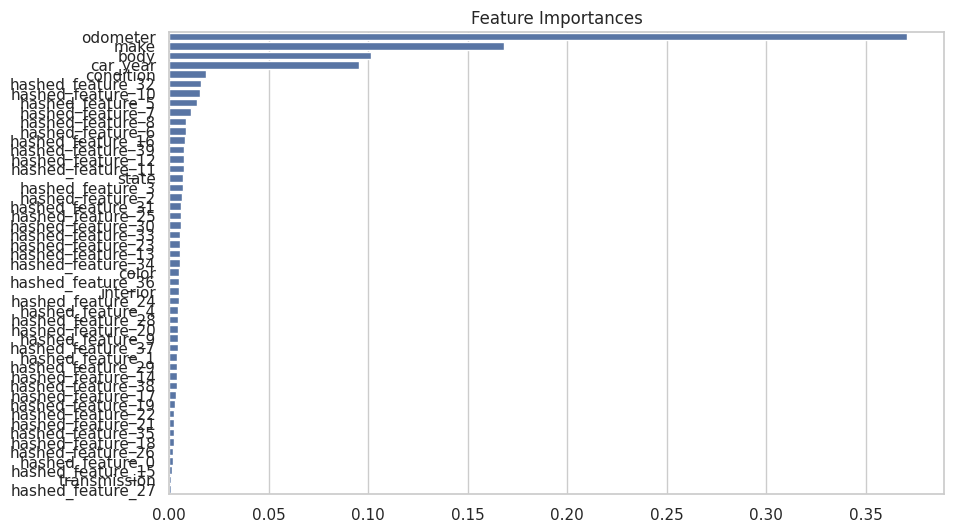

In [ ]:
# Feature importance
feature_importances = model.feature_importances_
plt.figure(figsize=(13,10))
feature_names = np.array(X_train.columns.tolist())
indices = np.argsort(feature_importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
sorted_feature_names = feature_names[indices]

# Create the plot
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances[indices], y=sorted_feature_names)
plt.title('Feature Importances')
plt.show()

In [ ]:
X_train.columns

Index(['make', 'body', 'transmission', 'state', 'condition', 'odometer',
       'color', 'interior', 'car_year', 'hashed_feature_0', 'hashed_feature_1',
       'hashed_feature_2', 'hashed_feature_3', 'hashed_feature_4',
       'hashed_feature_5', 'hashed_feature_6', 'hashed_feature_7',
       'hashed_feature_8', 'hashed_feature_9', 'hashed_feature_10',
       'hashed_feature_11', 'hashed_feature_12', 'hashed_feature_13',
       'hashed_feature_14', 'hashed_feature_15', 'hashed_feature_16',
       'hashed_feature_17', 'hashed_feature_18', 'hashed_feature_19',
       'hashed_feature_20', 'hashed_feature_21', 'hashed_feature_22',
       'hashed_feature_23', 'hashed_feature_24', 'hashed_feature_25',
       'hashed_feature_26', 'hashed_feature_27', 'hashed_feature_28',
       'hashed_feature_29', 'hashed_feature_30', 'hashed_feature_31',
       'hashed_feature_32', 'hashed_feature_33', 'hashed_feature_34',
       'hashed_feature_35', 'hashed_feature_36', 'hashed_feature_37',
       'hashed_

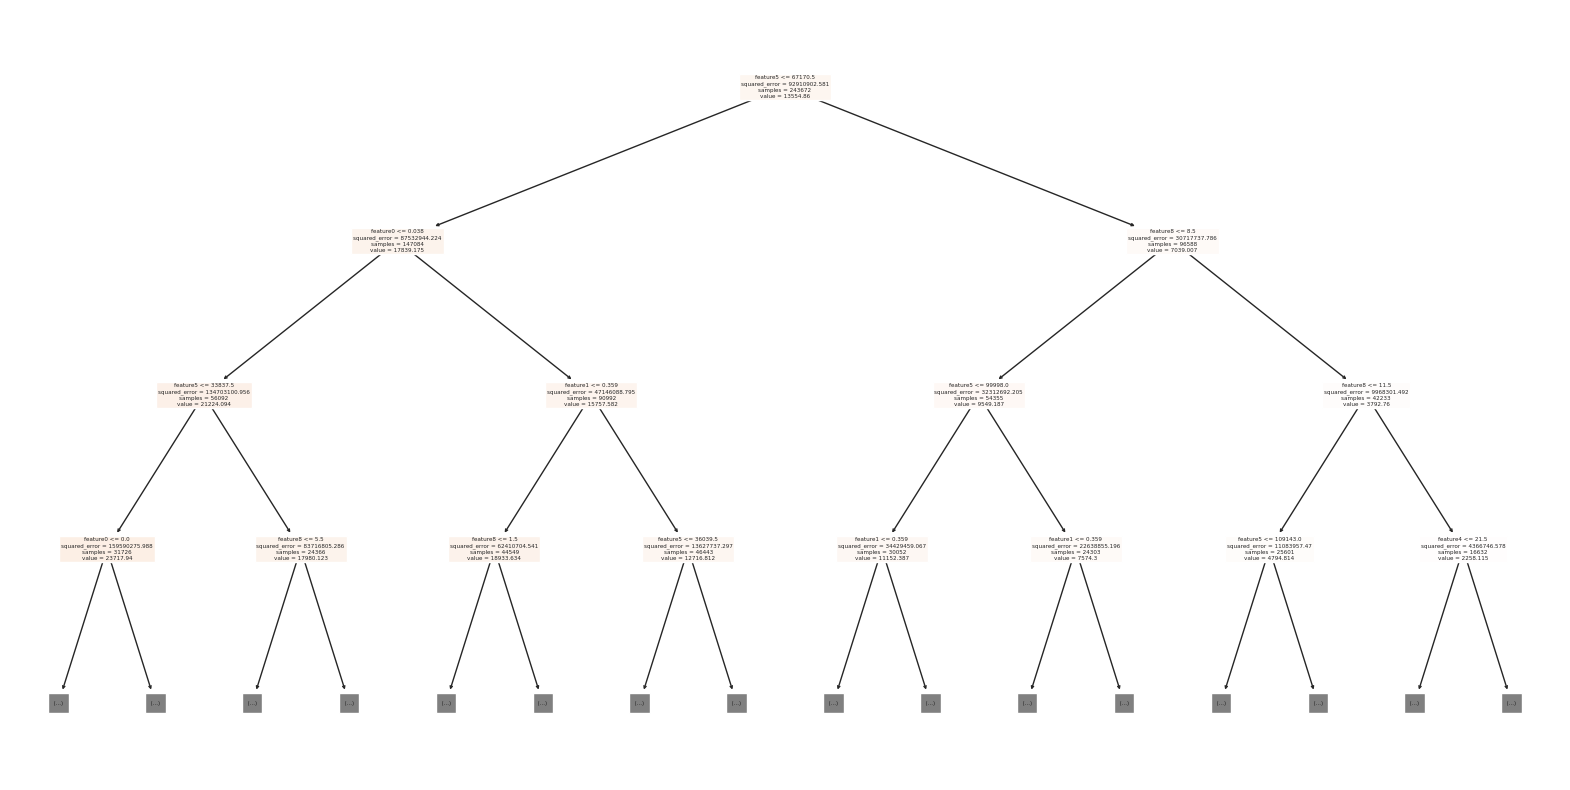

In [ ]:
# Plot tree figure for decision tree
from sklearn.tree import plot_tree
feature_names = X_train.columns.tolist()
tree = model.estimators_[0]
plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=['feature'+str(i) for i in range(X_train.shape[1])], max_depth=3)
plt.show()

system message after tune


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
Mean Absolute Error (MAE): 1523.4381673801731
Mean Squared Error (MSE): 6064058.957937365
Root Mean Squared Error (RMSE): 2462.531006492581
R-squared (R2): 0.9337371314844105

Mean Absolute Error (MAE): 1254.223141913164 \
Mean Squared Error (MSE): 4415281.623867252 \
Root Mean Squared Error (RMSE): 2101.2571531983544 \
R-squared (R2): 0.9517535651069711

In [ ]:
model = LGBMRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print_metrics(y_test, y_pred)

KeyboardInterrupt: 

We have trained LightGBM model, but the result is not ideal. This error is casued by manually interrupting the process, we have left this here since it is part of our training and testing process.

#5. Model Evaluation

#### 5.1 Selection of Model:
After examining the complexity and size of the database, we originally considered using simple linear regression as a baseline model. However, since we have removed the variable 'mmr', no other choice of a single feature would be suitable. The variable 'mmr' stands for the market report value (estimated market value). However, considering real-world scenarios, we are likely the stakeholders who will be predicting this value, and it would be irrational to include it as a predictor. Thus, we have decided to use multilinear regression as a baseline model. It shows relatively high errors in terms of MAE, MSE, and RMSE. We therefore tried decision tree and random forest regressor and observed an increase in performance, especially after some hyperparameter tuning via grid search.

We acknowledge further improvement can be made in implementing models with more complexity such as XGboost and LightGBM. Results produced by Neural Networks could be interesting as well.

#### 5.2 Model evaluation and comparison:



In [ ]:
variance_test = np.var(y_test)
min_test = min(y_test)
max_test = max(y_test)
mean_test = np.mean(y_test)
# Non-scientific Notation for better illustration
pd.options.display.float_format = '{:.2f}'.format

results_df = pd.DataFrame({
    "Statistic": ["Variance", "Minimum", "Maximum","Mean"],
    "Value": [variance_test, min_test, max_test, mean_test]
})
results_df

,Statistic,Value
0,Variance,91515189.33
1,Minimum,1.00
2,Maximum,167000.00
3,Mean,13529.72




We have selected MAE, MSE, RMSE, and R-square as our evaluation metrics for the models, this is because we are dealing with a regression problem and we have a continuous numerical outcome (selling price). The MAE, MSE, and RMSE are all measurements of the difference between predicted and actual values, lower values of these metrics indicate improved accuracy. On the other hand, R-square indicates the proportion of the variance in the outcome that is predictable from our features, meaning a higher value suggests the model explains a greater proportion of the variance.

Comparing the fitted **Decision Tree** and **Random Forest Models** with **baseline Multilinear Regression Model**, we can see a dramatically decreased error and increased explanability on variance. Moreover, in the table above, we can see the variance and range of the testing set of the outcome variable. Comparing our error in both models to these measurements, we conclude that our model's inaccuracy is within an acceptable range.

In terms of the comparison within our two models, **Decision Tree** and **Random Forest Models**. We see that the random forest model with default hyperparameter outperforms the fine-tuned decision tree model in terms of accuracy. We tried to further fine-tune the random forest model, but the performance was worse. This might be caused by the range we selected for hyperparameters to grid search, we can make improvements on this if time is allowed (it takes 6-9 hours to run a more complete grid search). In practical use cases, we also have to consider the tradeoff between accuracy and efficiency between random forest and decision tree models, while random forest has higher accuracy, it takes much longer to train and fine-tune the model compared to decision tree.